In [1]:
import torch
from torch.utils.data import DataLoader
from glob import glob
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from components.mymodel import load_model
from components.helper import train

In [2]:
from torch.utils.data import Dataset
from torchvision import io

class SoilDataset_phone(Dataset):
    def __init__(self, dataset_path:str, image_set:str, transform=None):
        assert os.path.exists(dataset_path), f"Path is not exist."

        image_folder = os.path.join(dataset_path, image_set)
        assert os.path.exists(image_folder), f"image_set={image_set} is not exists in {dataset_path}."
        self.imgs = glob(os.path.join(image_folder,'*'))
        print(f"Found {len(self.imgs)} images in {image_folder}.")
        
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        path, img_name_w_ext = os.path.split(img_path)
        name, ext = os.path.splitext(img_name_w_ext)
        # print(name)
        id, phone_brand, OM, lab_no, soil_character, place, variant = name.split('_')
        y = float(OM)
        y = torch.tensor(y)
        # print(y)
        X = io.read_image(img_path)
        if self.transform:
            X = self.transform(X)
        return X.float(), y.float(), img_name_w_ext

In [3]:
#We can check whether we have gpu
DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# DEVICE = 'cpu'
print("Device: ", DEVICE)

Device:  cuda:0


In [4]:
def get_model(model, image_set:str, epochs:int, lr:float):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        # transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    dataset = SoilDataset_phone(dataset_path='./dataset/phones/', image_set=image_set, transform=preprocess)
    loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=16)
    model, train_losses = train(model, loader, epochs, lr, DEVICE)
    plt.plot(train_losses)
    plt.title(image_set)
    plt.show()
    return model, train_losses

Found 775 images in ./dataset/phones/Apple.
9
19
29
39
49
59
69
79
89
99
109
119
129
139
149


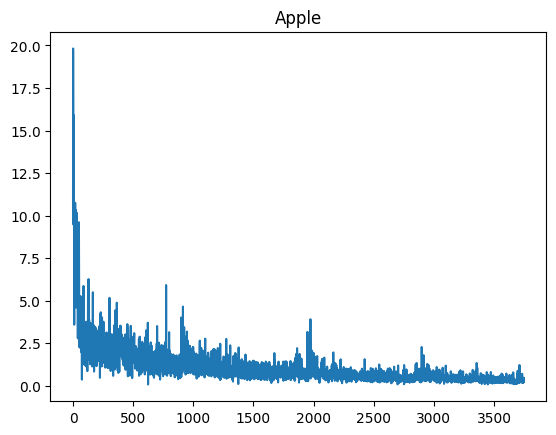

Found 795 images in ./dataset/phones/Oppo.
9
19
29
39
49
59
69
79
89
99
109
119
129


KeyboardInterrupt: 

In [6]:
image_set_list = next(os.walk('./dataset/phones/'))[1]
train_losses = []
# mobilenet_v3_large
# resnet50
# efficientnet_v2_l
# alexnet
model_name = 'alexnet'
weight_path = f'./weight/{model_name}'
epochs = 150
lr = 0.001

if(os.path.exists(weight_path) == False):
    os.makedirs(weight_path)
for image_set in image_set_list:
    # if(image_set == 'Apple'): continue
    model = load_model(model_name=model_name)
    model, train_loss = get_model(model, image_set, epochs, lr)
    train_losses.append(train_loss)
    torch.save(model.state_dict(), os.path.join(weight_path,f"{image_set}.pth"))